# The "Goodreads" Prize
In 2006, Netflix launched The "Netflix" prize: they provided 100 million (user, movie, rating) triplets, and asked people to come up with an algorithm to predict unknown ratings. This type of problem is known as [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), and is used to recommend unwatched movies to users. I decided to tackle this same problem, but targeted at book ratings on [Goodreads](http://www.goodreads.com/) instead of movie ratings from Netflix.

However, Goodreads hasn't provided me with a nice easy dataset (like Netflix) did, so first, I need to scrape some data myself.

In [1]:
import numpy as np
import pandas as pd
import pickle
import mpld3
import copy

import goodreadsFns as gr
import config

# load in api key from config file
#developer_key = config.DEVELOPER_KEY
#developer_secret = config.DEVELOPER_SECRET
#user_id = config.USER_ID # can overwrite user_id if desired
user_id = '39597914'

Fortunately, I wrote a function to pull all of the book ratings from a specific user using XML. The function takes a bit of time, because we want to be respectful of Goodreads and not make too many requests too frequently. The function also prints the size of the resulting data frame. In my case, I've rated 149 books on Goodreads, and we have a (user, book, rating) triplet for each book.

In [2]:
df = gr.pullBooks(user_id)
df.head()

(149, 3)


,rating,title,user
0,4,A Little Life,39597914
1,2,The Professor and the Madman: A Tale of Murder...,39597914
2,4,The Orphan Master's Son,39597914
3,4,Homegoing,39597914
4,4,The Buried Giant,39597914


In order to do any sort of collaborative filtering, we need lots of data from lots of users. When I have more time to tackle the Goodreads API and OAuth, I'll be able to automatically get all of a user's friends, and pull their books and ratings too. For now, though, I need to manually provide a list of user IDs and use a 'for' loop to iterate through them, pull their ratings, and concatenate the dataframes.

This code takes a very long time to run, so for convenience, I've saved all of the ratings in an easily-loadable CSV file.

In [3]:
# since we've already pulled the data and saved it as a CSV, it's easiest to just load that back in
df = pd.read_csv('book_ratings.csv', index_col=0, dtype='str')
print(df.shape)
df.head()

(2715, 3)


,rating,title,user
0,4,A Little Life,39597914
1,4,The Orphan Master's Son,39597914
2,4,Homegoing,39597914
3,4,The Buried Giant,39597914
4,5,The Blinds,39597914


Great! Now we've got a dataframe contained 2715 (user, book, rating) triplets from 13 different users. This dataset is tiny compared to the 100 million ratings that Netflix provided, but it should be large enough for a proof-of-concept.

One of the premier techniques for collaborative filtering is the nearest-neighbors algorithm. This can be performed in either "user-centric" or "book-centric" flavor. In the user-centric version, the goal is to find users who have rated books similarly to you (by looking at books that you have both rated), and then pick out books that they have rated highly but you haven't rated. In the book-centric version, the goal is to find unrated books that have been given similar ratings (by other users) to books that you have rated.

To prepare our data for the nearest-neighbors algorithm, we need to convert it from the sparse, efficient format it's currently in to a dense matrix with lots of missing elements. We also need to drop any duplicate entries (in case the same user rated the same book multiple times).

In [4]:
df_mat = df.drop_duplicates(subset=('title','user')).pivot(index='title', columns='user',values='rating')
print(df_mat.shape)
df_mat.head()

(1953, 13)


user,12041027,2283563,24262842,29377615,31236408,36672902,38345131,39597914,5052643,58736911,60428384,60946317,71721333
title,,,,,,,,,,,,,
"""E Unibus Pluram: Television and U.S. Fiction""",None,None,None,None,None,5,None,None,None,None,None,None,None
1-2-3 Magic: Effective Discipline for Children 2-12,None,None,None,None,0,None,None,None,None,None,None,None,None
10:04,None,None,None,None,None,5,None,None,None,None,None,None,None
13 Ways of Looking at the Novel,None,None,None,None,None,3,None,None,None,None,None,None,None
1491: New Revelations of the Americas Before Columbus,None,None,None,5,None,None,None,None,None,None,None,None,None


Now instead of 2715 triplets, we have a matrix of 1953 books by 13 users, where most of entries are unknown. Our goal is to fill in these entries!

One drawback to nearest-neighbors is that all of the books need to defined relative to one another. Therefore, any book that has only been rated by one user needs to be removed from the dataset. Our numbers also need to be converted to floats so they can be properly worked with.

In [5]:
# remove books that were only rated by one person
df_mat = df_mat[df_mat.notna().sum(axis=1)>1]
df_mat = df_mat.astype(float)
print(df_mat.shape)
df_mat.head()

(394, 13)


user,12041027,2283563,24262842,29377615,31236408,36672902,38345131,39597914,5052643,58736911,60428384,60946317,71721333
title,,,,,,,,,,,,,
1984,NaN,4.0,5.0,5.0,3.0,3.0,5.0,4.0,NaN,4.0,4.0,0.0,NaN
1Q84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN
A Clash of Kings,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
A Clockwork Orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,3.0,NaN
A Confederacy of Dunces,NaN,4.0,NaN,NaN,4.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN


After removing books with only one rating, we can now see that there are only 394 books (out of the original 1953) that have actually been rated by more than one users, and the vast majority of those books have only been rated by two users.

We can also look and see what the most-rated books are in this simple. My friends and I have pretty strong tendencies towards sci-fi/fantasy, dystopian, and classic novels, so it's not very surprising to me to see that reflected here.

<IPython.core.display.Javascript object>


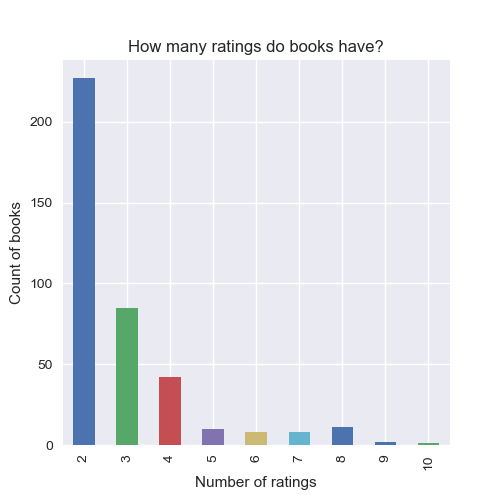

title
1984                                         10
The Great Gatsby                              9
Fahrenheit 451                                9
Harry Potter and the Sorcerer's Stone         8
Cat's Cradle                                  8
The Hitchhiker's Guide to the Galaxy          8
Harry Potter and the Chamber of Secrets       8
Harry Potter and the Goblet of Fire           8
Harry Potter and the Half-Blood Prince        8
Harry Potter and the Order of the Phoenix     8
Harry Potter and the Prisoner of Azkaban      8
Brave New World                               8
Of Mice and Men                               8
Lord of the Flies                             8
dtype: int64


In [6]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(5,5))
df_mat.notna().sum(axis=1).value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('How many ratings do books have?')
ax.set_xlabel('Number of ratings')
ax.set_ylabel('Count of books')
print(df_mat.notna().sum(axis=1).sort_values(ascending=False)[0:14])
plt.show()

Before jumping straight to nearest-neighbors, it's also worthwhile to look at how similar or different a book's set of ratings is from other books. To do this, I want to create a $b$ by $b$ matrix (where $b$ is the total number of books rated). I then want to fill in each element $B_{ij} = B_{ji}$ with some number that describes how different book $i$ and book $j$ are from each other. This is similar to the book-centric nearest-neighbors algorithm described above, but the resulting "distance matrix" will also allow us to use multidimensional scaling to visualize these similarities conveniently in two dimensions.

One problem here, though: different books will have different numbers of raters in common. For example, the distance between Book A and Book B may be calculated based on 4 users (the number of users that rated both books), whereas the distance between Book A and Book C may only be based on 2 users. To compensate for this, I'm going to divide each distance by the square-root of the number of users used to calculate the distance. I'm also going to artifically inflate each distance by adding 1, to preserve the intuition that Book B can't be as similar to Book A as Book A is to itself (this problem would go away on its own if I had more data).

#### Creating a book distance matrix
1. For each pair of books, calculate Euclidean distance between ratings (only using subjects who rated each pair) and add 1 to it.
2. Normalize distances by sqrt(d), where d is the dimension used to calculate the distance (i.e., the number of ratings used).

In [7]:
pkl_file = open('distance.pkl', 'rb')
distance_matrix = pickle.load(pkl_file)
dimension_matrix = pickle.load(pkl_file)
pkl_file.close()

distance_matrix

array([[0.31622777, 3.62258273, 2.28824561, ..., 3.62258273, 3.15933917,
        1.41421356],
       [3.62258273, 0.70710678,        inf, ..., 1.        , 1.        ,
        1.        ],
       [2.28824561,        inf, 0.70710678, ..., 1.        ,        inf,
               inf],
       ...,
       [3.62258273, 1.        , 1.        , ..., 0.70710678, 1.        ,
               inf],
       [3.15933917, 1.        ,        inf, ..., 1.        , 0.5       ,
               inf],
       [1.41421356, 1.        ,        inf, ...,        inf,        inf,
        0.70710678]])

In [8]:
dimension_matrix

array([[10.,  2.,  2., ...,  2.,  3.,  2.],
       [ 2.,  2.,  0., ...,  1.,  1.,  1.],
       [ 2.,  0.,  2., ...,  1.,  0.,  0.],
       ...,
       [ 2.,  1.,  1., ...,  2.,  1.,  0.],
       [ 3.,  1.,  0., ...,  1.,  4.,  0.],
       [ 2.,  1.,  0., ...,  0.,  0.,  2.]])

Because I calculated the distances a little oddly, I now need to do some post-processing. First, because I added 1 to all distances and then divided by the (square-root of the) number of common raters, any pairs of books that had no raters in common will end up with distances of 1/0 = inf. These inf values need to be changed to nans.

Second, because of these same changes, I'm now ending up with non-zero distances on my diagonal. Since a book is identical to itself (which is the same as a distance of zero), I need to change all of my diagonal elements back to zeros.

In [9]:
# do some extra processing now because of the +1 above

# convert inf to nan
distance_matrix[np.isinf(distance_matrix)] = np.nan

# convert diagonal elements to 0s
np.fill_diagonal(distance_matrix, 0)

distance_matrix

array([[0.        , 3.62258273, 2.28824561, ..., 3.62258273, 3.15933917,
        1.41421356],
       [3.62258273, 0.        ,        nan, ..., 1.        , 1.        ,
        1.        ],
       [2.28824561,        nan, 0.        , ..., 1.        ,        nan,
               nan],
       ...,
       [3.62258273, 1.        , 1.        , ..., 0.        , 1.        ,
               nan],
       [3.15933917, 1.        ,        nan, ..., 1.        , 0.        ,
               nan],
       [1.41421356, 1.        ,        nan, ...,        nan,        nan,
        0.        ]])

Voila! Now I can visualize how different each book is from every other book using a heatmap. More blue colors correspond to books that are more similar, more yellow colors correspond to books that are more different, and white squares represent books with no raters in common.

<IPython.core.display.Javascript object>


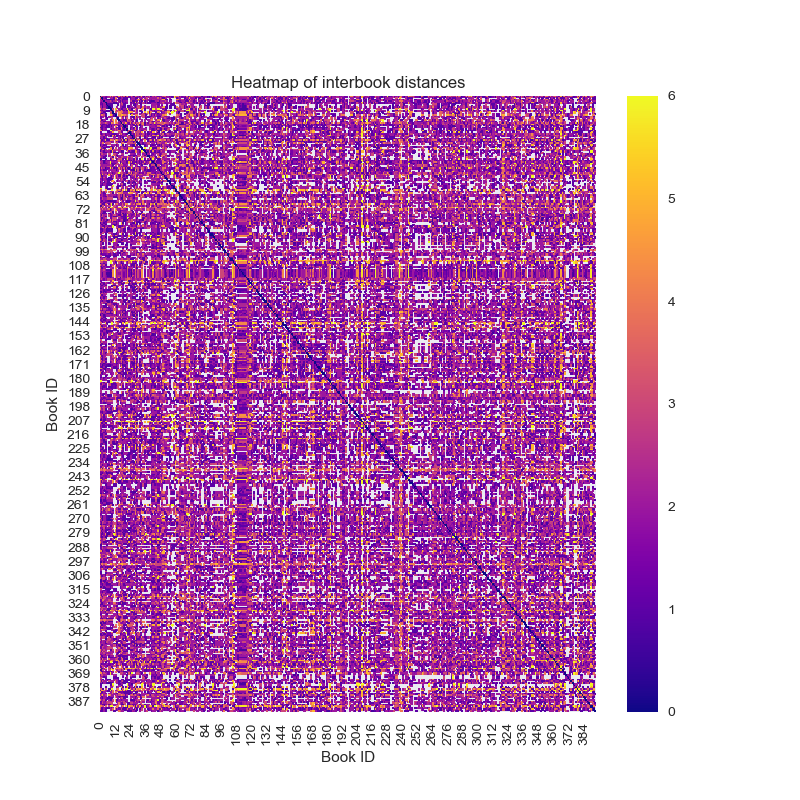

Text(0.5,1,'Heatmap of interbook distances')

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(distance_matrix, ax=ax, cmap = 'plasma')
ax.set_xlabel('Book ID')
ax.set_ylabel('Book ID')
ax.set_title('Heatmap of interbook distances')

We can also look at the distribution of distances across all book-book pairings. As expected (given the sparsity of the matrix), we see distinct books at the integers (1, 2, 3, etc.), corresponding to book-book pairs with only one rater in common (and are therefore divided by the square-root of 1).

<IPython.core.display.Javascript object>


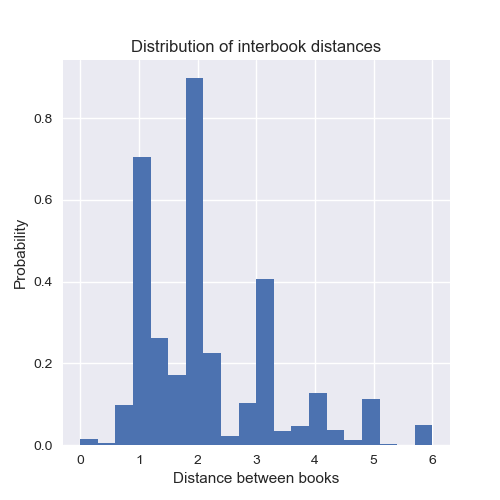

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(distance_matrix[np.isfinite(distance_matrix)], bins=20, density=True)
ax.set_xlabel('Distance between books')
ax.set_ylabel('Probability')
ax.set_title('Distribution of interbook distances')
plt.show()

While pretty to look at, distance matrices on their own tend to not be very informative on their own. Their real power comes when they are combined with multidimensional scaling (MDS), an algorithm that takes in distances between a number of items, and finds the two-dimensional arrangement of those items that maximally preserves those distances. For an intuitive guide to MDS (in R), [see here](http://personality-project.org/r/mds.html).

In [12]:
# try non-metric multidimensional scaling (NMDS)
# apparently, NMDS can accommodate missing data by making them 0s
# reference: https://stackoverflow.com/questions/17529646/nan-inf-values-in-scikit-learn-manifold-learning-functions
# also pulling from: http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html
distance_NMDS = distance_matrix
distance_NMDS[np.isnan(distance_NMDS)] = 0 # convert to 0

from sklearn.manifold import MDS

nmds = MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", n_jobs=1, n_init=1)

npos = nmds.fit(distance_NMDS).embedding_

<IPython.core.display.Javascript object>


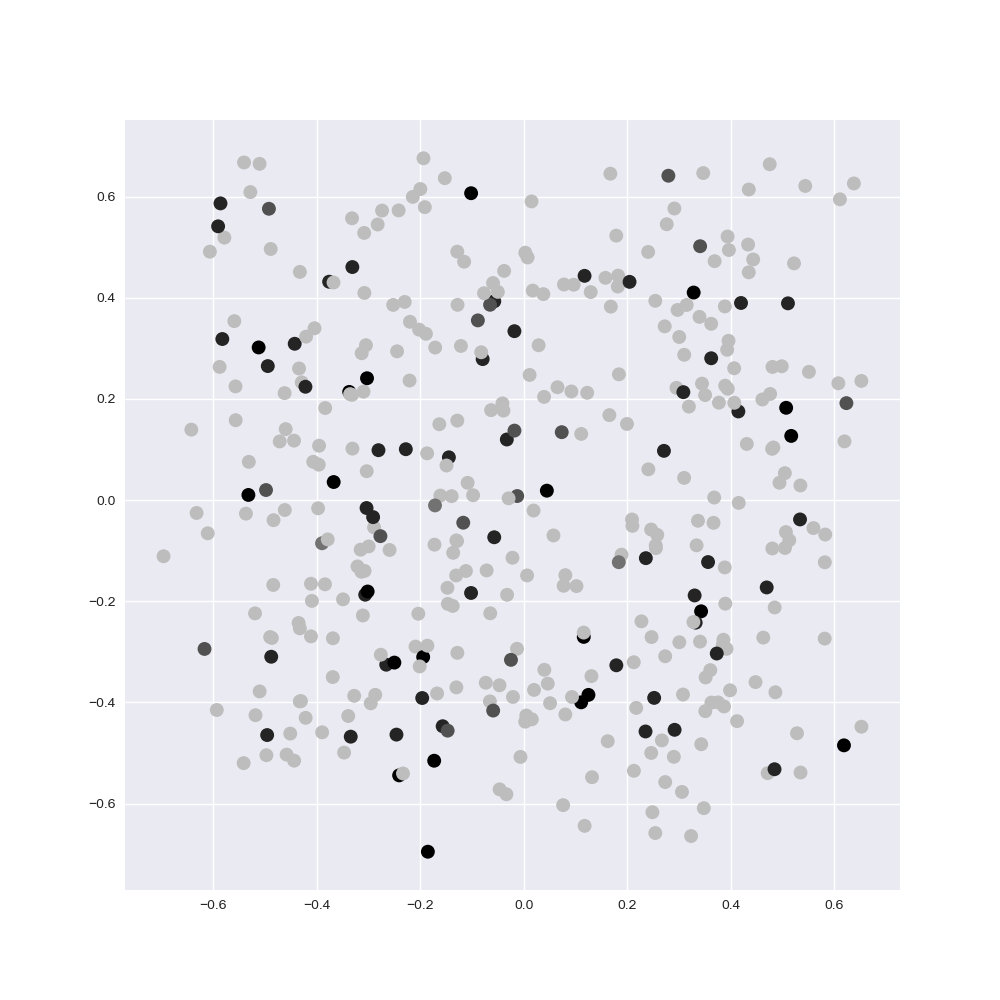

In [13]:
# pick one subject, and plot colors according to their rankings
user_id = '39597914'
user_rankings = df_mat[user_id]
norm = plt.Normalize(-3,5)
cmap = plt.cm.Greys
c = copy.copy(user_rankings)
c[np.isnan(c)] = 0

fig, ax = plt.subplots(figsize=(10,10))

sc = plt.scatter(npos[:,0], npos[:,1], c=c, s=100, lw=0, cmap=cmap, norm=norm)
names = df_mat.index.values


annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = ''
    for num,n in enumerate(ind["ind"]):
        string = '{}: {}'.format(user_rankings[n], names[n])
        if num==0:
            text = text + string
        else:
            text = text + '\n' + string
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(1)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", hover)

plt.show()

Explore the figure by clicking on different dots. The dots are colored by my ratings, with the darkest dots being books that I've rated 5/5, and the lightest dots being books that I haven't rated. Clicking a dot will display a bubble with the name and my rating of the book(s).

There's a problem here though, that I think this figure visualizes quite well: sparsity. If we want to take a nearest-neighbors approach to collaborative filtering, we need to have a reasonable guess at what those neighbors are, and that becomes a really difficult thing to do when there is little overlap between the books that each user rates.

A better strategy is to use matrix factorization (factor analysis, singular value decomposition, etc.). The goal of matrix factorization is to use the data that we do have to predict our missing entries. This is identical, in theory, to imputation. The difference is one of scale and intent: in imputation, we're typically trying to fill in just a few missing datapoints and then run some other algorithm on the full dataset, but here the purpose is to fill in *many* missing datapoints and that is the final goal.

### Collaborative filtering using matrix factorization
One problem with matrix factorization methods like singular value decomposition (SVD) is that they become very computationally intensive with large matrices. Here (and in the Netflix Prize), we have very large, but mostly empty, matrices. If only there were a way to perform SVD but only using the data that we do have...enter "incremental SVD".

Going to center data$^*$ and then use Simon Funk's incremental SVD algorithm for matrix factorization to "impute" the missing values in my ratings matrix. Recommend links are here: [article by Koren, Bell, and Volinsky](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf), [lecture slides by Serdar Sali](https://classes.soe.ucsc.edu/cmps242/Winter08/proj/serdar_talk.pdf), and [blog post by Simon Funk](http://sifter.org/~simon/journal/20061211.html).

$^*$In an ideal world, I'd subtract off the average book rating across *all* users. However, that's a little more difficult to do because the Goodreads API isn't stellar to use in Python, so for now, I'll have to settle for the average book rating amongst users in my data set.

In [14]:
n_users = df_mat.shape[1]
n_books = df_mat.shape[0]

# subtract off average rating from each book
avg_rating_by_book = df_mat.mean(axis=1).mean()
avg_rating_by_user = df_mat.mean(axis=0).mean()
avg_book_rating = df_mat.mean(axis=1) - avg_rating_by_book
avg_user_rating = df_mat.mean(axis=0) - avg_rating_by_user

mu = np.tile(avg_rating_by_book,(n_books,n_users))
book_bias = np.tile(avg_book_rating,(n_users,1)).T
user_bias = np.tile(avg_user_rating,(n_books,1))

array_norm = df_mat.values - mu - book_bias - user_bias
df_norm = pd.DataFrame(data=array_norm,index=df_mat.index,columns=df_mat.columns)
df_norm.head()

user,12041027,2283563,24262842,29377615,31236408,36672902,38345131,39597914,5052643,58736911,60428384,60946317,71721333
title,,,,,,,,,,,,,
1984,NaN,0.312397,0.601578,0.570915,-0.84121,-1.239318,1.494407,-0.151633,NaN,-0.147976,0.344335,-3.924666,NaN
1Q84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048367,NaN,NaN,NaN,-0.724666,NaN
A Clash of Kings,NaN,NaN,NaN,NaN,0.85879,NaN,NaN,NaN,NaN,NaN,-0.955665,NaN,NaN
A Clockwork Orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118300,NaN,NaN,0.377668,-0.891333,NaN
A Confederacy of Dunces,NaN,-0.487603,NaN,NaN,-0.64121,-0.039318,NaN,0.048367,NaN,NaN,NaN,NaN,NaN


In [15]:
# reconvert into (user, book, rating) triplets, and add numerically-coded identifiers for books and users
df_list = copy.copy(df_norm.stack().reset_index())
df_list = df_list.rename(axis=1, mapper={'title':'book',0:'rating'})
df_list['book_code'] = df_list['book'].astype('category').cat.codes
df_list['user_code'] = df_list['user'].astype('category').cat.codes

The basic principle of incremental SVD is that we can step through each (user, book, rating) triplet one-by-one and use gradient descent to update our factorized matrices based on that single data point. We have a few free parameters that we initially need to define: the learning rate, regularization penalty, number of features in our model, and what to initialize those features to.

<IPython.core.display.Javascript object>


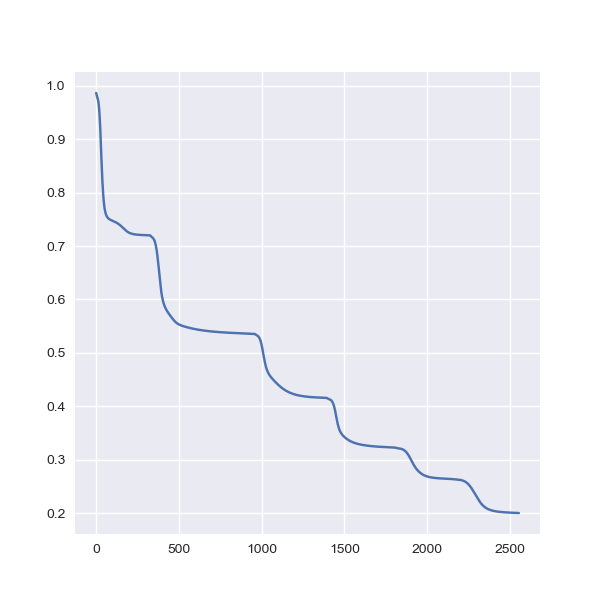

In [16]:
# load factorized matrices and plot RMSE over iterations
pkl_file = open('data.pkl', 'rb')
userFeature = pickle.load(pkl_file)
bookFeature = pickle.load(pkl_file)
RMSE = pickle.load(pkl_file)
iter_per_feat = pickle.load(pkl_file)
pkl_file.close()

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(RMSE)

In [17]:
predicted_ratings = np.matmul(bookFeature, userFeature.T) + mu + book_bias + user_bias
predicted_ratings

array([[ 4.93331840e+00,  4.14463742e+00,  4.78207922e+00, ...,
         3.60123707e+00,  4.42738972e-01, -1.69046032e+00],
       [ 5.41255392e+00,  4.41424656e+00,  4.84984629e+00, ...,
         4.16166968e+00,  3.89457463e+00,  8.26816717e-01],
       [ 4.72881375e+00,  3.74311934e+00,  3.51219026e+00, ...,
         3.01887936e+00,  1.87655108e+00,  5.25928831e-03],
       ...,
       [ 3.66920289e+00,  4.22438137e+00,  5.06363105e+00, ...,
         3.02064714e+00,  3.99517938e+00, -7.57993634e-01],
       [ 5.16312625e+00,  4.00416560e+00,  4.45154670e+00, ...,
         3.68364200e+00,  4.02243805e+00,  5.17658639e-01],
       [ 5.26962628e+00,  5.58636179e+00,  6.68958859e+00, ...,
         4.84574977e+00,  5.41181600e+00,  6.80228441e-01]])